Mapping des politiques :
| Nom du candidat       | Position politique         | Code |
| --------------------- | -------------------------- | ---- |
| Nathalie ARTHAUD      | Extrême gauche (LO)        | 1    |
| Philippe POUTOU       | Extrême gauche (NPA)       | 1    |
| Fabien ROUSSEL        | Gauche (PCF)               | 2    |
| Jean-Luc MÉLENCHON    | Gauche radicale (LFI)      | 2    |
| Yannick JADOT         | Écologiste (EELV)          | 3    |
| Anne HIDALGO          | Centre gauche (PS)         | 3    |
| Emmanuel MACRON       | Centre / centre-droit      | 4    |
| Valérie PÉCRESSE      | Droite (LR)                | 5    |
| Nicolas DUPONT-AIGNAN | Droite souverainiste (DLF) | 5    |
| Éric ZEMMOUR          | Extrême droite identitaire | 6    |
| Marine LE PEN         | Extrême droite (RN)        | 6    |
| Jean LASSALLE         | Inclassable / ruraliste    | 4    |


In [1]:
import pandas as pd
import numpy as np


from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("..\MSPR_ETL\TransformedData\jdd.csv")
mapping_politique = {
    'ARTHAUD': 1,
    'POUTOU': 1,
    'ROUSSEL': 2,
    'MÉLENCHON': 2,
    'JADOT': 3,
    'HIDALGO': 3,
    'MACRON': 4,
    'LASSALLE': 4,
    'PÉCRESSE': 5,
    'DUPONT-AIGNAN': 5,
    'LE PEN': 6,
    'ZEMMOUR': 6
}

In [3]:
df['libelle_politique'] = df['nom'].map(mapping_politique)
df = df.drop(columns=['prenom', 'nom'])

In [4]:
infos_departement = df.drop_duplicates(subset='code_departement')[
    ['code_departement', 'taux_chomage',
     'Autres coups et blessures volontaires', 'Cambriolages de logement',
     'Coups et blessures volontaires', 'Coups et blessures volontaires intrafamiliaux',
     'Destructions et dégradations volontaires', 'Escroqueries', 'Homicides',
     'Tentatives d\'homicides', 'Trafic de stupéfiants', 'Usage de stupéfiants',
     'Usage de stupéfiants (AFD)', 'Violences sexuelles', 'Vols avec armes',
     'Vols d\'accessoires sur véhicules', 'Vols dans les véhicules',
     'Vols de véhicules', 'Vols sans violence contre des personnes',
     'Vols violents sans arme']
]
infos_departement

,code_departement,taux_chomage,Autres coups et blessures volontaires,Cambriolages de logement,Coups et blessures volontaires,Coups et blessures volontaires intrafamiliaux,Destructions et dégradations volontaires,Escroqueries,Homicides,Tentatives d'homicides,Trafic de stupéfiants,Usage de stupéfiants,Usage de stupéfiants (AFD),Violences sexuelles,Vols avec armes,Vols d'accessoires sur véhicules,Vols dans les véhicules,Vols de véhicules,Vols sans violence contre des personnes,Vols violents sans arme
0,01,5.5,1.281117,7.298735,3.190876,1.909759,6.328124,5.337492,0.013407,0.020855,0.320279,2.155555,1.336235,1.357091,0.050649,1.440512,1.967856,1.565645,4.795252,0.169822
12,02,10.5,1.908448,6.270937,4.682642,2.774194,8.490024,4.745432,0.011416,0.043763,0.428116,3.769327,1.946503,1.832338,0.049471,1.588788,1.710563,1.914156,4.912874,0.272092
24,03,7.7,1.601362,3.820371,3.432771,1.831409,7.678174,5.667508,0.000000,0.065728,0.460093,3.417833,1.953901,1.434056,0.041827,0.881347,1.574474,0.818607,5.096874,0.203158
36,04,8.2,1.967950,3.777988,4.468265,2.500314,8.954474,7.028395,0.005982,0.035890,0.376842,4.187129,1.411661,1.579146,0.053835,1.082672,3.164273,1.399697,6.190969,0.263191
48,05,6.9,2.032793,2.130443,4.750242,2.717449,9.069927,5.420781,0.028233,0.007058,0.451732,4.390268,1.856335,1.750461,0.014117,0.698773,1.785752,0.875230,7.023017,0.127050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,971,18.6,3.874140,4.254819,8.397446,4.523306,7.578819,3.798534,0.070391,0.430170,0.797770,4.259990,2.179530,1.720681,0.969839,0.969839,4.825729,1.585112,7.169505,0.860341
1164,972,12.5,3.609228,3.198135,7.692116,4.082888,6.093862,4.057958,0.080328,0.354552,1.077506,3.465192,1.891867,1.930646,0.667555,0.750653,3.251906,1.296331,4.972037,0.678635
1176,973,13.1,5.017650,10.574418,9.494351,4.476701,4.962168,2.316372,0.166446,0.811424,2.919738,1.400920,0.665784,2.340645,3.034170,0.547884,4.733305,2.035495,7.153706,2.108315
1188,974,18.1,2.474618,2.261071,6.687483,4.212865,5.824033,2.072961,0.018154,0.046520,0.246214,1.438705,0.671698,1.950421,0.046520,0.375561,1.687188,1.169799,3.756745,0.479947


In [5]:
resultats = df.groupby(['code_departement', 'libelle_politique'])['voix'].sum().reset_index()


In [6]:
resultats

,code_departement,libelle_politique,voix
0,01,1,3830
1,01,2,63770
2,01,3,21487
3,01,4,103082
4,01,5,26570
...,...,...,...
601,976,2,8604
602,976,3,613
603,976,4,6295
604,976,5,3340


In [7]:
final_df = pd.merge(resultats, infos_departement, on='code_departement', how='left')
final_df.dtypes

code_departement                                  object
libelle_politique                                  int64
voix                                               int64
taux_chomage                                      object
Autres coups et blessures volontaires            float64
Cambriolages de logement                         float64
Coups et blessures volontaires                   float64
Coups et blessures volontaires intrafamiliaux    float64
Destructions et dégradations volontaires         float64
Escroqueries                                     float64
Homicides                                        float64
Tentatives d'homicides                           float64
Trafic de stupéfiants                            float64
Usage de stupéfiants                             float64
Usage de stupéfiants (AFD)                       float64
Violences sexuelles                              float64
Vols avec armes                                  float64
Vols d'accessoires sur véhicule

In [8]:
final_df

,code_departement,libelle_politique,voix,taux_chomage,Autres coups et blessures volontaires,Cambriolages de logement,Coups et blessures volontaires,Coups et blessures volontaires intrafamiliaux,Destructions et dégradations volontaires,Escroqueries,...,Trafic de stupéfiants,Usage de stupéfiants,Usage de stupéfiants (AFD),Violences sexuelles,Vols avec armes,Vols d'accessoires sur véhicules,Vols dans les véhicules,Vols de véhicules,Vols sans violence contre des personnes,Vols violents sans arme
0,01,1,3830,5.5,1.281117,7.298735,3.190876,1.909759,6.328124,5.337492,...,0.320279,2.155555,1.336235,1.357091,0.050649,1.440512,1.967856,1.565645,4.795252,0.169822
1,01,2,63770,5.5,1.281117,7.298735,3.190876,1.909759,6.328124,5.337492,...,0.320279,2.155555,1.336235,1.357091,0.050649,1.440512,1.967856,1.565645,4.795252,0.169822
2,01,3,21487,5.5,1.281117,7.298735,3.190876,1.909759,6.328124,5.337492,...,0.320279,2.155555,1.336235,1.357091,0.050649,1.440512,1.967856,1.565645,4.795252,0.169822
3,01,4,103082,5.5,1.281117,7.298735,3.190876,1.909759,6.328124,5.337492,...,0.320279,2.155555,1.336235,1.357091,0.050649,1.440512,1.967856,1.565645,4.795252,0.169822
4,01,5,26570,5.5,1.281117,7.298735,3.190876,1.909759,6.328124,5.337492,...,0.320279,2.155555,1.336235,1.357091,0.050649,1.440512,1.967856,1.565645,4.795252,0.169822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,976,2,8604,nd,4.915834,6.063887,7.130104,2.214270,7.929268,1.980368,...,0.272885,0.588653,0.105256,1.680194,2.475460,0.222207,2.070030,1.504768,4.498710,1.921892
602,976,3,613,nd,4.915834,6.063887,7.130104,2.214270,7.929268,1.980368,...,0.272885,0.588653,0.105256,1.680194,2.475460,0.222207,2.070030,1.504768,4.498710,1.921892
603,976,4,6295,nd,4.915834,6.063887,7.130104,2.214270,7.929268,1.980368,...,0.272885,0.588653,0.105256,1.680194,2.475460,0.222207,2.070030,1.504768,4.498710,1.921892
604,976,5,3340,nd,4.915834,6.063887,7.130104,2.214270,7.929268,1.980368,...,0.272885,0.588653,0.105256,1.680194,2.475460,0.222207,2.070030,1.504768,4.498710,1.921892


In [10]:
final_df = final_df.apply(lambda col: pd.to_numeric(col.astype(str).str.replace(',', '.'), errors='coerce'))
final_df.dropna(inplace=True)
final_df.tail()

,code_departement,libelle_politique,voix,taux_chomage,Autres coups et blessures volontaires,Cambriolages de logement,Coups et blessures volontaires,Coups et blessures volontaires intrafamiliaux,Destructions et dégradations volontaires,Escroqueries,...,Trafic de stupéfiants,Usage de stupéfiants,Usage de stupéfiants (AFD),Violences sexuelles,Vols avec armes,Vols d'accessoires sur véhicules,Vols dans les véhicules,Vols de véhicules,Vols sans violence contre des personnes,Vols violents sans arme
595,974.0,2,142678,18.1,2.474618,2.261071,6.687483,4.212865,5.824033,2.072961,...,0.246214,1.438705,0.671698,1.950421,0.04652,0.375561,1.687188,1.169799,3.756745,0.479947
596,974.0,3,13543,18.1,2.474618,2.261071,6.687483,4.212865,5.824033,2.072961,...,0.246214,1.438705,0.671698,1.950421,0.04652,0.375561,1.687188,1.169799,3.756745,0.479947
597,974.0,4,67386,18.1,2.474618,2.261071,6.687483,4.212865,5.824033,2.072961,...,0.246214,1.438705,0.671698,1.950421,0.04652,0.375561,1.687188,1.169799,3.756745,0.479947
598,974.0,5,18076,18.1,2.474618,2.261071,6.687483,4.212865,5.824033,2.072961,...,0.246214,1.438705,0.671698,1.950421,0.04652,0.375561,1.687188,1.169799,3.756745,0.479947
599,974.0,6,98840,18.1,2.474618,2.261071,6.687483,4.212865,5.824033,2.072961,...,0.246214,1.438705,0.671698,1.950421,0.04652,0.375561,1.687188,1.169799,3.756745,0.479947


In [13]:
y = final_df['voix']
X = final_df.drop(columns=['voix'])

In [ ]:
# !pip install catboost


In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100,
    random_seed=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²: {r2:.2%}")


0:	learn: 69329.1840005	total: 824us	remaining: 823ms
100:	learn: 16981.2536291	total: 59.3ms	remaining: 528ms
200:	learn: 8824.8392052	total: 120ms	remaining: 478ms
300:	learn: 5622.6749161	total: 190ms	remaining: 442ms
400:	learn: 3761.6694693	total: 257ms	remaining: 384ms
500:	learn: 2716.8364033	total: 318ms	remaining: 317ms
600:	learn: 1959.8626101	total: 372ms	remaining: 247ms
700:	learn: 1457.8841871	total: 426ms	remaining: 182ms
800:	learn: 1077.7953478	total: 479ms	remaining: 119ms
900:	learn: 835.2079612	total: 531ms	remaining: 58.4ms
999:	learn: 630.9989506	total: 599ms	remaining: 0us
✅ RMSE: 27726.15
✅ R²: 77.02%


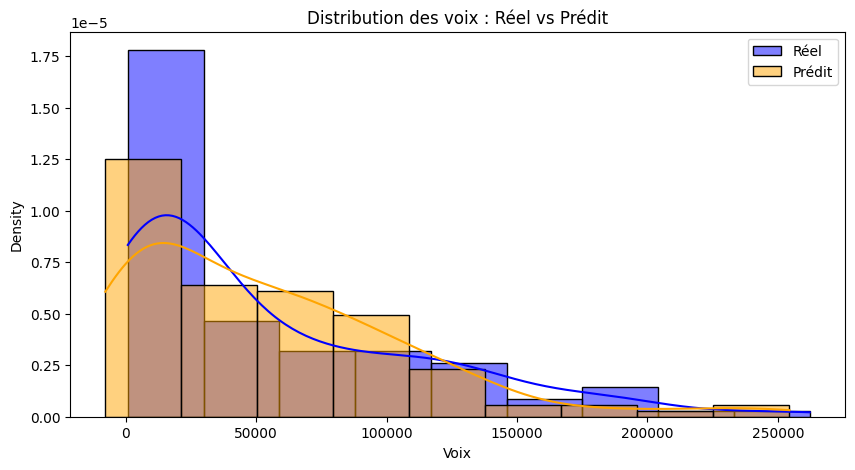

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(y_test, color='blue',
              label='Réel', 
              kde=True, stat="density")
sns.histplot(y_pred, color='orange', 
             label='Prédit',
               kde=True, stat="density")
plt.legend()
plt.title("Distribution des voix : Réel vs Prédit")
plt.xlabel("Voix")
plt.show()

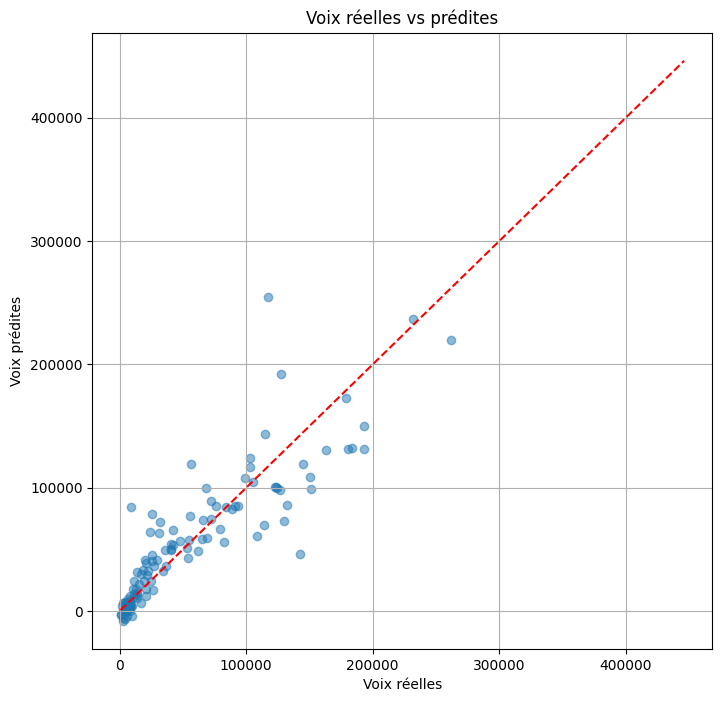

In [16]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Voix réelles")
plt.ylabel("Voix prédites")
plt.title("Voix réelles vs prédites")
plt.grid(True)
plt.show()


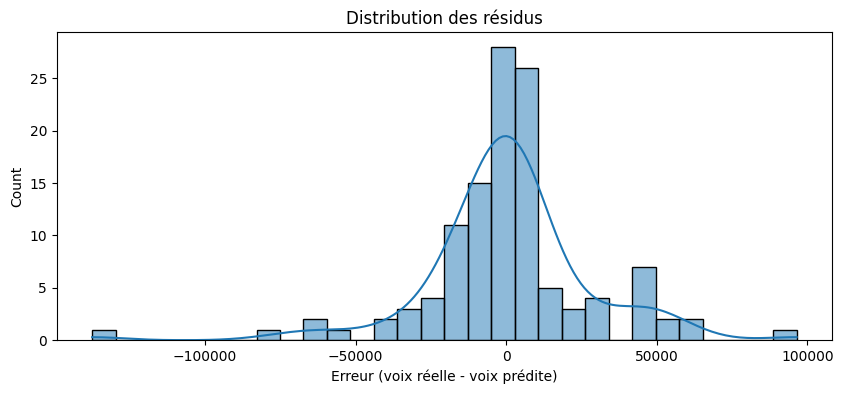

In [17]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution des résidus")
plt.xlabel("Erreur (voix réelle - voix prédite)")
plt.show()

In [18]:
feature_importances = model.get_feature_importance(prettified=True)
feature_importances

,Feature Id,Importances
0,libelle_politique,54.925777
1,Vols dans les véhicules,6.027694
2,Vols sans violence contre des personnes,5.400874
3,Vols violents sans arme,5.063534
4,Cambriolages de logement,2.392001
5,Vols d'accessoires sur véhicules,2.316257
6,taux_chomage,2.066733
7,Vols avec armes,2.041601
8,Usage de stupéfiants (AFD),1.996514
9,Violences sexuelles,1.854760


In [21]:
final_df['classement'] = final_df.groupby('code_departement')['voix'].rank(ascending=False, method='first').astype(int)


In [22]:
final_df

,code_departement,libelle_politique,voix,taux_chomage,Autres coups et blessures volontaires,Cambriolages de logement,Coups et blessures volontaires,Coups et blessures volontaires intrafamiliaux,Destructions et dégradations volontaires,Escroqueries,...,Usage de stupéfiants,Usage de stupéfiants (AFD),Violences sexuelles,Vols avec armes,Vols d'accessoires sur véhicules,Vols dans les véhicules,Vols de véhicules,Vols sans violence contre des personnes,Vols violents sans arme,classement
0,1.0,1,3830,5.5,1.281117,7.298735,3.190876,1.909759,6.328124,5.337492,...,2.155555,1.336235,1.357091,0.050649,1.440512,1.967856,1.565645,4.795252,0.169822,6
1,1.0,2,63770,5.5,1.281117,7.298735,3.190876,1.909759,6.328124,5.337492,...,2.155555,1.336235,1.357091,0.050649,1.440512,1.967856,1.565645,4.795252,0.169822,3
2,1.0,3,21487,5.5,1.281117,7.298735,3.190876,1.909759,6.328124,5.337492,...,2.155555,1.336235,1.357091,0.050649,1.440512,1.967856,1.565645,4.795252,0.169822,5
3,1.0,4,103082,5.5,1.281117,7.298735,3.190876,1.909759,6.328124,5.337492,...,2.155555,1.336235,1.357091,0.050649,1.440512,1.967856,1.565645,4.795252,0.169822,2
4,1.0,5,26570,5.5,1.281117,7.298735,3.190876,1.909759,6.328124,5.337492,...,2.155555,1.336235,1.357091,0.050649,1.440512,1.967856,1.565645,4.795252,0.169822,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,974.0,2,142678,18.1,2.474618,2.261071,6.687483,4.212865,5.824033,2.072961,...,1.438705,0.671698,1.950421,0.046520,0.375561,1.687188,1.169799,3.756745,0.479947,1
596,974.0,3,13543,18.1,2.474618,2.261071,6.687483,4.212865,5.824033,2.072961,...,1.438705,0.671698,1.950421,0.046520,0.375561,1.687188,1.169799,3.756745,0.479947,5
597,974.0,4,67386,18.1,2.474618,2.261071,6.687483,4.212865,5.824033,2.072961,...,1.438705,0.671698,1.950421,0.046520,0.375561,1.687188,1.169799,3.756745,0.479947,3
598,974.0,5,18076,18.1,2.474618,2.261071,6.687483,4.212865,5.824033,2.072961,...,1.438705,0.671698,1.950421,0.046520,0.375561,1.687188,1.169799,3.756745,0.479947,4


In [62]:
from catboost import CatBoostClassifier

X = final_df.drop(columns=['voix', 'classement'])
y = final_df['classement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=50
)


In [63]:
model.fit(X_train, y_train)

0:	learn: 0.6000000	total: 2.67ms	remaining: 1.33s
50:	learn: 0.8319149	total: 111ms	remaining: 974ms
100:	learn: 0.9191489	total: 206ms	remaining: 815ms
150:	learn: 0.9723404	total: 332ms	remaining: 767ms
200:	learn: 0.9914894	total: 428ms	remaining: 636ms
250:	learn: 1.0000000	total: 520ms	remaining: 516ms
300:	learn: 1.0000000	total: 610ms	remaining: 404ms
350:	learn: 1.0000000	total: 708ms	remaining: 300ms
400:	learn: 1.0000000	total: 800ms	remaining: 197ms
450:	learn: 1.0000000	total: 888ms	remaining: 96.5ms
499:	learn: 1.0000000	total: 977ms	remaining: 0us


In [64]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [65]:

y_pred = model.predict(X_test)
y_pred = y_pred.flatten() 

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8050847457627118

Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.79      0.81        19
           2       0.71      0.63      0.67        19
           3       0.83      0.95      0.88        20
           4       0.76      0.65      0.70        20
           5       0.70      0.80      0.74        20
           6       1.00      1.00      1.00        20

    accuracy                           0.81       118
   macro avg       0.80      0.80      0.80       118
weighted avg       0.80      0.81      0.80       118



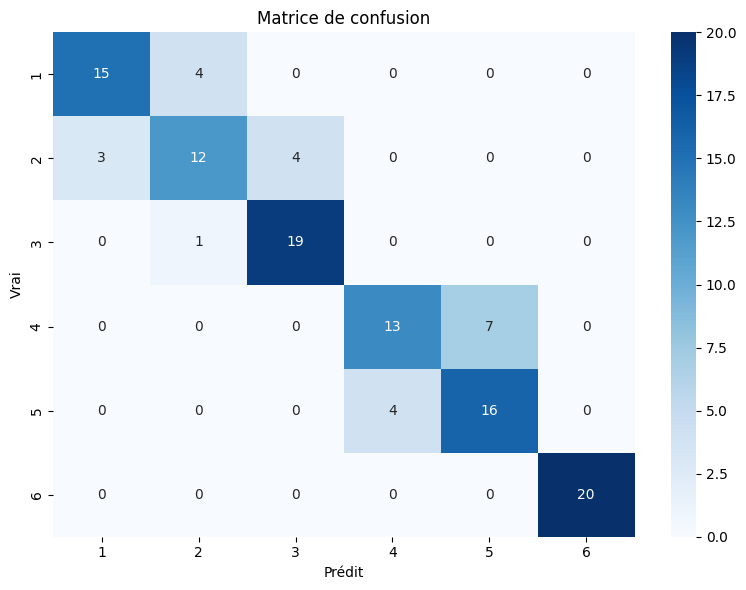

In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Matrice de confusion')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.tight_layout()
plt.show()


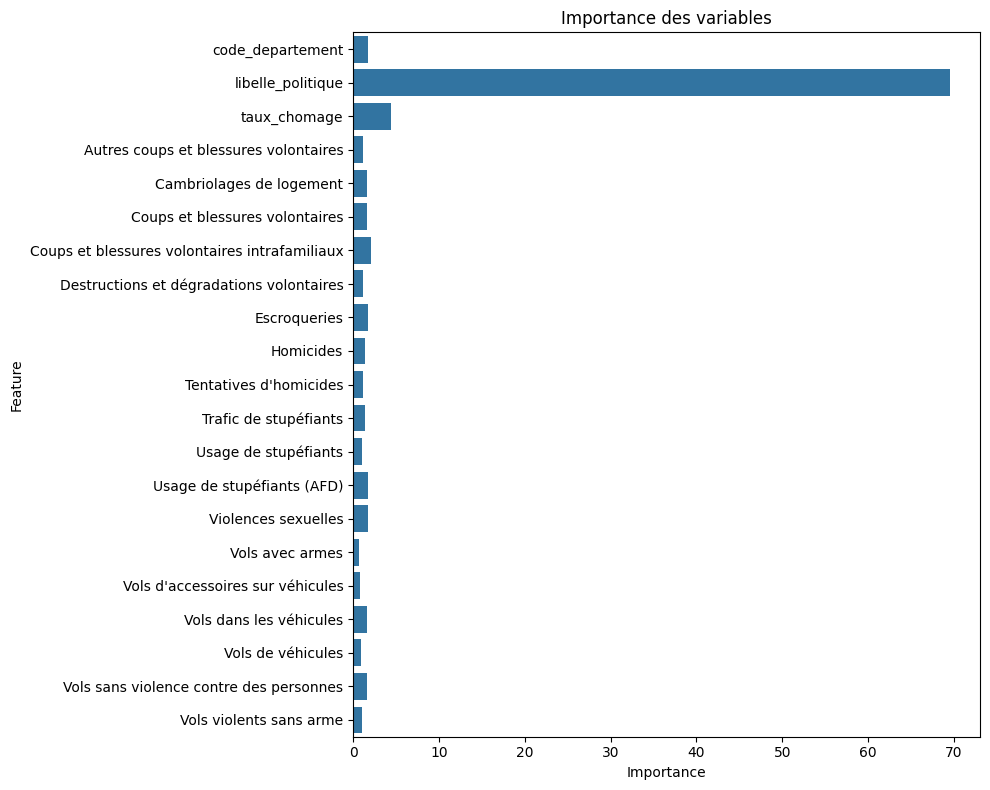

In [67]:
importances = model.get_feature_importance()
features = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=importances, y=features)
plt.title('Importance des variables')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()